<a href="https://colab.research.google.com/github/LeoFernanndes/portfolio/blob/master/ChicagoTaxiRidePrice_parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

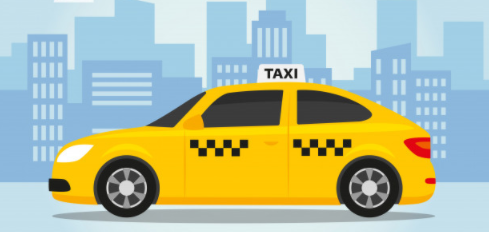

# Chicago Taxi Ride Price Regression

Tivemos uma ideia genial de concorrer com os táxis no mercado de mobilidade urbana. Para verificar uma das hipóteses para viabilidade da nossa start up, decidimos tentar de alguma forma estimar os custos das viagens dos nossos concorrentes dados local de partida e chegada, forma de pagamento, dia e hora. Pra nossa sorte, o departamento de transportes da cidade disponibiliza um registro com essas informações.

In [ ]:
!pip install haversine # biblioteca usada para calcular distâncias baseadas em coordenadas

In [ ]:
import pandas as pd


pd.options.display.max_rows = 50

url = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/chicago_taxi_sample_50k.csv'
df_taxi = pd.read_csv(url)

df_baseline = df_taxi.copy()
df_baseline

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,ride_date
0,d3c594ba6b3eb5f9644b9af3f1328aa82744ffd5,a0ac953f8cee6f14d8f2f15bf14b52de5caab289f7d599...,2019-09-13 23:00:00+00:00,2019-09-13 23:00:00+00:00,60.0,0.0,NaN,NaN,7.0,7.0,3.25,0.00,0.0,0.0,3.25,Cash,Taxi Affiliation Services,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),2019-09-13
1,cac1926e5b4ca977decbf9079ffd4b02cae90503,b5e2695a2f44b9bce7a0a86148ac418802f0067be1f6d4...,2014-06-19 18:00:00+00:00,2014-06-19 18:15:00+00:00,840.0,2.3,NaN,NaN,24.0,8.0,9.85,2.00,0.0,0.0,11.85,Credit Card,NaN,41.901207,-87.676356,POINT (-87.6763559892 41.90120699410001),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),2014-06-19
2,ab1adf76a077d31a82824264aed032f197423f5d,41afbb1073e9c58a6dbdfff8ad24160d01c862ca34c520...,2018-08-24 16:00:00+00:00,2018-08-24 16:45:00+00:00,3180.0,0.9,1.703198e+10,1.703108e+10,76.0,8.0,41.00,9.20,0.0,5.0,55.20,Credit Card,Taxi Affiliation Services,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.907413,-87.640902,POINT (-87.6409015248 41.9074128162),2018-08-24
3,d19b9b5131a749b6c8fee6661a84833421c1e25f,6daab772b2fe0e6dcb68884525d6ad9d44ce74ecaeb417...,2015-06-20 12:15:00+00:00,2015-06-20 12:30:00+00:00,540.0,2.9,1.703108e+10,1.703107e+10,8.0,7.0,9.44,2.00,0.0,0.0,11.44,Credit Card,NaN,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.929263,-87.635891,POINT (-87.6358909539 41.9292629902),2015-06-20
4,48262d526cc41442f947b81a3ab0f60174fc66cc,11f73b08790612efe341cf8cf69cadbcb7732293794186...,2018-08-10 21:00:00+00:00,2018-08-10 21:00:00+00:00,600.0,1.6,1.703128e+10,1.703108e+10,28.0,8.0,7.50,1.50,0.0,0.0,9.00,Credit Card,Choice Taxi Association,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2018-08-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,a3a6c9af9051d48af2b7b2fbdf02c962fa9a9ca9,cc33cdc1816a9ba9822dd033062f8d414cac183bbfa7fc...,2014-06-20 13:00:00+00:00,2014-06-20 13:00:00+00:00,515.0,1.6,1.703108e+10,1.703128e+10,8.0,28.0,7.25,2.00,NaN,1.0,10.25,Credit Card,American United,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.879255,-87.642649,POINT (-87.642648998 41.8792550844),2014-06-20
49996,33b1fb15a4e0b417f8dcee508993db379abd0039,45bd8de07cb28a2d16874f8ba527f094fe8b68dceb5f59...,2014-06-30 14:30:00+00:00,2014-06-30 14:45:00+00:00,1140.0,1.0,NaN,NaN,69.0,69.0,10.45,0.00,0.0,1.0,11.45,Cash,Choice Taxi Association,41.763247,-87.616134,POINT (-87.6161341112 41.7632467988),41.763247,-87.616134,POINT (-87.6161341112 41.7632467988),2014-06-30
49997,cf5dbfda73e899b9889024b9ee51a97a4df72489,5c4dbf120a97d6d82d93388ef3ec44ea96fff151a5f179...,2014-09-20 01:45:00+00:00,2014-09-20 01:45:00+00:00,240.0,1.1,1.703183e+10,1.703107e+10,7.0,7.0,5.65,2.00,0.0,1.0,8.65,Credit Card,Choice Taxi Association,41.914747,-87.654007,POINT (-87.6540070286 41.9147473049),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),2014-09-20
49998,dbac35b3e6a4ac99f8c691aaf885abc2f43cb4ca,6682944f2b37609761181033253037c05fed4377e8b649...,2019-07-23 16:00:00+00:00,2019-07-23 16:30:00+00:00,1500.0,0.0,NaN,NaN,32.0,15.0,25.75,0.00,0.0,5.0,30.75,Cash,Star North Management LLC,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487),2019-07-23


In [ ]:
# verificando dados faltantes
df_baseline.isnull().sum().sort_values(ascending=False)

dropoff_census_tract      17429
pickup_census_tract       17213
company                    8719
tolls                      8428
dropoff_community_area     6799
dropoff_longitude          6662
dropoff_latitude           6662
dropoff_location           6662
pickup_community_area      5883
pickup_location            5878
pickup_longitude           5878
pickup_latitude            5878
trip_seconds                325
trip_end_timestamp            9
tips                          2
fare                          2
trip_total                    2
taxi_id                       2
extras                        2
trip_start_timestamp          0
ride_date                     0
trip_miles                    0
payment_type                  0
unique_key                    0
dtype: int64

Pra começar, vamos estabelecer o mínimo aceitável para um modelo de regressão nesse conjunto de dados. 

Pra isso, vamos preencher os dados faltantes com a mediana dos dados numéricos e a moda dos dados categóricos e treinar um modelo padrão. Esse processo é conhecido como a definição do modelo baseline.

In [ ]:
df_baseline.dtypes

unique_key                 object
taxi_id                    object
trip_start_timestamp       object
trip_end_timestamp         object
trip_seconds              float64
trip_miles                float64
pickup_census_tract       float64
dropoff_census_tract      float64
pickup_community_area     float64
dropoff_community_area    float64
fare                      float64
tips                      float64
tolls                     float64
extras                    float64
trip_total                float64
payment_type               object
company                    object
pickup_latitude           float64
pickup_longitude          float64
pickup_location            object
dropoff_latitude          float64
dropoff_longitude         float64
dropoff_location           object
ride_date                  object
dtype: object

In [ ]:
for column in df_baseline.columns:
  if df_baseline[column].dtype == 'object':
    df_baseline[column] = df_baseline[column].fillna(df_baseline[column].mode()[0]) # mode[0] porque em arrays multimodais, selecionamos apenas a primeira
  else:
    df_baseline[column] = df_baseline[column].fillna(df_baseline[column].median())

df_baseline.isnull().sum().sort_values(ascending=False) # nenhum dado faltante

ride_date                 0
dropoff_location          0
taxi_id                   0
trip_start_timestamp      0
trip_end_timestamp        0
trip_seconds              0
trip_miles                0
pickup_census_tract       0
dropoff_census_tract      0
pickup_community_area     0
dropoff_community_area    0
fare                      0
tips                      0
tolls                     0
extras                    0
trip_total                0
payment_type              0
company                   0
pickup_latitude           0
pickup_longitude          0
pickup_location           0
dropoff_latitude          0
dropoff_longitude         0
unique_key                0
dtype: int64

Uma outra necessidade para o modelo de regressão que vamos usar como o baseline é a transformação de todos os inputs em dados numéricos. Esse é o processo de encoding e nós vamos usar aqui qualquer um sem muiito critério só pra fazer a previsão mais simples possível e verificar o resultado

In [ ]:
from sklearn.preprocessing import LabelEncoder

for column in df_baseline.columns:
  if df_baseline[column].dtype == 'object':
    le = LabelEncoder()
    df_baseline[column] = le.fit_transform(df_baseline[column])

df_baseline.dtypes # agora todos os campos são int ou float

unique_key                  int64
taxi_id                     int64
trip_start_timestamp        int64
trip_end_timestamp          int64
trip_seconds              float64
trip_miles                float64
pickup_census_tract       float64
dropoff_census_tract      float64
pickup_community_area     float64
dropoff_community_area    float64
fare                      float64
tips                      float64
tolls                     float64
extras                    float64
trip_total                float64
payment_type                int64
company                     int64
pickup_latitude           float64
pickup_longitude          float64
pickup_location             int64
dropoff_latitude          float64
dropoff_longitude         float64
dropoff_location            int64
ride_date                   int64
dtype: object

Vamos olhar aqui para os preço base das corridas descontando gorjetas e extras.

Como a coluna trip_total contém a coluna fare que é o que queremos prever, também precisamos removê-la. Lembro isso agora porque eu mesmo acabei deixando passar esse detalhe e tive que voltar pra corrigir.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


x_columns = ['unique_key', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'pickup_location', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_location', 'ride_date']

y_column = 'fare'


x_train, x_test, y_train, y_test = train_test_split(df_baseline[x_columns], df_baseline[y_column], train_size=0.7)
regression_model = RandomForestRegressor()
regression_model.fit(x_train, y_train)
y_pred = regression_model.predict(x_test)


import numpy as np


# avaliando o resultado
error = y_test - y_pred
print('Custo médio da corrida ($): {}'. format(y_test.mean()))
print('Erro médio da previsão ($): {:1.3f}'. format(error.mean())) # uma maneira de mostrar menos casas decimais
print('Desvio padrão do erro ($): {}'. format( np.round(error.std(), 3) )) # uma outra maneira de melhorar a cara da resposta

Custo médio da corrida ($): 12.74831999999996
Erro médio da previsão ($): -0.070
Desvio padrão do erro ($): 5.78


In [ ]:
n_maiores_erros = round(len(y_test) * 0.001)

print(f'{n_maiores_erros} Maiores erros:')
print(error.sort_values(ascending=False)[:n_maiores_erros])
print()

print('Custo médio (limpo) da corrida ($): {}'. format(y_test.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Erro médio (limpo) da previsão ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Desvio padrão (limpo) do erro ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].std())) # note a redução do desvio ao eliminar o milésimo mais alto dos erros 

15 Maiores erros:
1804     217.9310
29355    181.9690
37936    167.2365
40899     92.1060
33127     89.9145
47886     85.4450
14974     80.0760
31343     78.4960
48119     76.1587
2138      72.0369
37954     61.8675
5846      58.0135
36272     55.8520
3315      54.8358
46801     53.0746
Name: fare, dtype: float64

Custo médio (limpo) da corrida ($): 12.63566099432768
Erro médio (limpo) da previsão ($): -0.16541169169169323
Desvio padrão (limpo) do erro ($): 4.683252465095323


Rodando mais de uma vez esse mesmo script até aqui, vamos ver que os valores de erro médio e desvio do erro mudam muito entre as execuções. Isso porque na hora de fazer a divisão entre dados de treino e teste, essas porções vêm aleatorizadas e sempre diferentes. 

Algumas formas de reduzir essa variabilidade podem ser:

- Fazer fazer uma comparação entre os dados de treino e teste pra verificar o quanto as amostras são similares antes de fazer a previsão

- Fazer o treino e teste repetidas vezes e considerar como previsão "oficial" a mediana entre essas previsões pra suavizar as variações

- Aproveitar que temos 50k registros e remover os outliers sem peso na consciênica

No fim das contas, é uma boa fazer um pouquinho de tudo e checar os resultados e aí entra uma outra pauta para os nossos estudos: 
quais metricas escolher para dizer se o nosso modelo é bom ou não?

Por enquanto vamos aceitar que o nosso número mágico é esse desvio padrão limpo, que ele  é uma medida interessante pra esse erro e que a distruibuição desse erro se aproxima de uma normal. Isso porque em uma distribuição normal, o desvio padrão assume importante papel de definir os intervalos de confiança para as nossas previsões.

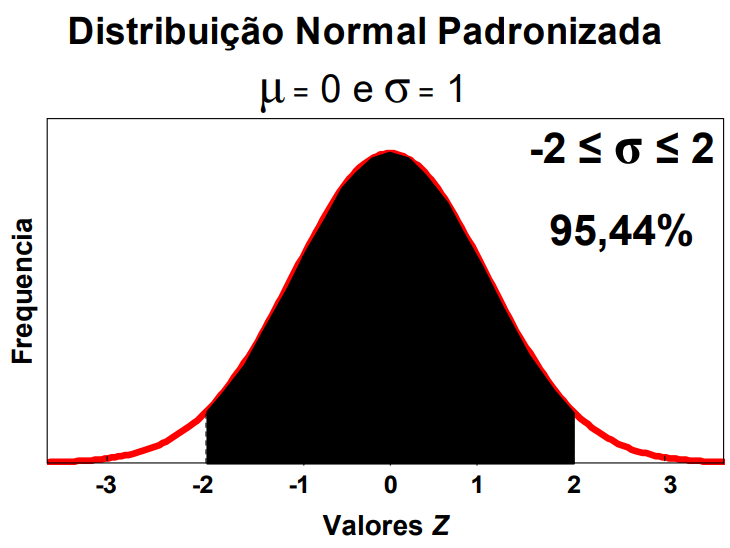


Desse modo, um desvio padrão de 0.5 nos diria que podemos confiar que 95.44% dos nossos erros vão estar entre -1 e +1. Se a nossa média é 13.85, estamos falando de um intervalo de confiança que engloba erros de até 7% pra mais ou pra menos. O que já me parece uma previsão bem assertiva.


In [ ]:
# o nosso baseline considerou para os dados faltantes, as medianas para valores numéricos e as modas para dados categóricos
# vamos tratar agora do nosso dataframe apenas com os dados reais, jogando fora os registros com ao menos uma das colunas nulas
df1 = df_taxi.copy()
df1.dropna(inplace=True)
df1

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,ride_date
2,ab1adf76a077d31a82824264aed032f197423f5d,41afbb1073e9c58a6dbdfff8ad24160d01c862ca34c520...,2018-08-24 16:00:00+00:00,2018-08-24 16:45:00+00:00,3180.0,0.9,1.703198e+10,1.703108e+10,76.0,8.0,41.00,9.2,0.0,5.0,55.20,Credit Card,Taxi Affiliation Services,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.907413,-87.640902,POINT (-87.6409015248 41.9074128162),2018-08-24
4,48262d526cc41442f947b81a3ab0f60174fc66cc,11f73b08790612efe341cf8cf69cadbcb7732293794186...,2018-08-10 21:00:00+00:00,2018-08-10 21:00:00+00:00,600.0,1.6,1.703128e+10,1.703108e+10,28.0,8.0,7.50,1.5,0.0,0.0,9.00,Credit Card,Choice Taxi Association,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2018-08-10
5,f5a6afb4daedb37b82500baf34cf41adcf7ca167,fcff47c0714c3d1a1ee9f6c36ea2854b938fadea98f2b5...,2013-03-01 19:15:00+00:00,2013-03-01 19:30:00+00:00,540.0,18.0,1.703108e+10,1.703108e+10,8.0,8.0,7.65,0.0,0.0,1.0,8.65,Cash,Taxi Affiliation Services,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),2013-03-01
7,8c7eb6c919ccc5197f9f97255f3eb5cd8ab6a0b1,07588fc5119d1c29249afc3e41417094185f808c12ff3d...,2013-02-22 21:15:00+00:00,2013-02-22 21:30:00+00:00,840.0,0.0,1.703106e+10,1.703103e+10,6.0,77.0,10.25,0.0,0.0,0.0,10.25,Cash,Northwest Management LLC,41.938391,-87.638575,POINT (-87.6385749205 41.938391257700005),41.978875,-87.657871,POINT (-87.6578712629 41.9788750584),2013-02-22
10,f06a3db639297271c4a1f5b3704d5c0790d62620,1c87f263c28aad874e0931b598767aeab2dbb7bbdb89d5...,2018-02-23 13:15:00+00:00,2018-02-23 13:30:00+00:00,1020.0,4.2,1.703184e+10,1.703108e+10,33.0,8.0,14.00,2.0,0.0,0.0,16.00,Credit Card,Choice Taxi Association,41.849247,-87.624135,POINT (-87.6241352979 41.84924675450001),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),2018-02-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49979,67d56b52bde3b66d747f7b45dfab4b73431e2c2d,af3b4b23f34495cb17ffb1b5ba884c08a6266690661eb2...,2018-03-14 17:15:00+00:00,2018-03-14 17:30:00+00:00,180.0,0.5,1.703184e+10,1.703108e+10,32.0,8.0,4.75,2.0,0.0,0.0,6.75,Credit Card,Star North Management LLC,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2018-03-14
49980,b953c75c172ea36d7be6b59be1e71307c6ed0c59,926aca65cddbfce7915dde52b9dad1eeba3a34763f280c...,2017-07-19 10:15:00+00:00,2017-07-19 10:30:00+00:00,600.0,0.0,1.703108e+10,1.703108e+10,8.0,8.0,7.50,1.0,0.0,0.0,8.50,Credit Card,Blue Ribbon Taxi Association Inc.,41.905858,-87.630865,POINT (-87.6308650266 41.9058577688),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2017-07-19
49991,bd399345026e933c8c9720433f3f7ef70ab2f6d3,1d6d1609c02f50bdd45ffcbe08fb36ce7908b2ff08b421...,2014-05-03 01:15:00+00:00,2014-05-03 01:15:00+00:00,240.0,1.5,1.703106e+10,1.703106e+10,6.0,6.0,6.05,0.0,0.0,1.0,7.05,Cash,Dispatch Taxi Affiliation,41.953400,-87.646007,POINT (-87.6460070664 41.9534000435),41.945282,-87.661545,POINT (-87.6615450961 41.9452823311),2014-05-03
49994,2a66652862821235e5a24e9a6dc28e1663c41fcd,519324bbc26a62489bfa3f3d64b74a0e62c7e455ef266b...,2015-08-14 11:45:00+00:00,2015-08-14 12:00:00+00:00,240.0,0.6,1.703184e+10,1.703108e+10,32.0,8.0,4.65,0.0,0.0,0.0,4.65,Cash,Taxi Affiliation Services,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),2015-08-14


In [ ]:
for column in df1.columns:
  if df1[column].dtype == 'object':
    le = LabelEncoder()
    df1[column] = le.fit_transform(df1[column])

x_columns = ['unique_key', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'pickup_location', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_location', 'ride_date']

y_column = 'fare'    
  
x_train, x_test, y_train, y_test = train_test_split(df1[x_columns], df1[y_column], train_size=0.7)
regression_model = RandomForestRegressor()
regression_model.fit(x_train, y_train)
y_pred = regression_model.predict(x_test)

error = y_test - y_pred
print('Custo médio da corrida ($): {}'. format(y_test.mean()))
print('Erro médio da previsão ($): {:1.3f}'. format(error.mean()))
print('Desvio padrão do erro ($): {}'. format( np.round(error.std(), 3) ))
print()

n_maiores_erros = round(len(y_test) * 0.001)

print(f'{n_maiores_erros} Maiores erros:')
print(error.sort_values(ascending=False)[:n_maiores_erros])
print()

print('Custo médio (limpo) da corrida ($): {}'. format(y_test.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Erro médio (limpo) da previsão ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Desvio padrão (limpo) do erro ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].std())) # veja que a eliminação dos registros de menor qualidade ainda proporciona um bom aumento na precisão

Custo médio da corrida ($): 11.595995070856432
Erro médio da previsão ($): -0.046
Desvio padrão do erro ($): 2.752

6 Maiores erros:
18154    65.4505
24216    64.5055
21604    54.3235
7342     50.4475
33011    46.5935
12226    44.6670
Name: fare, dtype: float64

Custo médio (limpo) da corrida ($): 11.523041936478593
Erro médio (limpo) da previsão ($): -0.0960700740055502
Desvio padrão (limpo) do erro ($): 2.186989420057881


Essa abordagem de simplesmente jogar fora todas a linhas que tinham ao menos um campo com dados faltantes custou mais da metade do nosso dataset, mas aparentemente esse segundo modelo traz resultados ligeiramente melhores. Digo aparentemente porque como comentado ali em cima, é necessário um certo cuidado pra comparar valores previstos, mas nesse nosso caso, rodei umas 6 ou 7 vezes e já que em todas, o segundo modelo desempenhou melhor que o primero, vamos aceitar que a melhora é real. 

Um possível problema dessa metodologia de eliminar os registros com dados faltantes é tirar a capacidade do modelo entender registros incompletos na hora de fazer uma previsão de verdade. Pode ser que exista alguma relação entre os registros com dados faltantes que nós vamos desconsiderar se simplemente fizermos essa eliminação. Se ele nunca viu um registro sem informação na coluna company por exemplo, o que ele vai fazer caso isso aconteça em produção? Pra esse nosso exemplo, acho que não é esse o caso, mas fica aí uma análise a ser feita: separar uma porção de dados com valores faltantes em diversas colunas e ver como esse modelo que nunca viu valores nulos vai se comportar.

## Análise exploratória de dados

Se nós pararmos pra ver um pouquinho mais de perto essa nossa base, vamos perceber que de cara, uma coluna não faz diferença nenhuma nos resultados da nossa previsão: unique_key. 
O que um índice pode acescentar de informação pra fazer o modelo acertar o preco das corridas? 
Mais que saber que eliminar o indíce simplifica o modelo sem degradar os resultados, podemos procurar entender quais são as variáveis que mais contribuem para a previsão mais acertada. Isso é a EDA (exploratory data analysis).

In [ ]:
# nós poderíamos partir do df1 que é a versão limpa do dataframe, mas é importante saber também como os dados nulos se distribuem
df = df_taxi.copy()

Nessa olhada meio por cima que nós demos nos nosso dados, podem ter surgido algumas dúvidas:

Em que dia da semana acontecem mais corridas? Em que horários? Quais os impactos dessa variação de demanda nos preços das corridas? Existe algum tipo de fluxo de entre regiões nas diversas horas do dia? Quais são as regiôes com mais movimento? E as formas de pagamento preferidas pelo pessoal? Qual a distânica média da corrida? Todas as empresas de táxi têm os mesmo preços? O preço varia de acordo com a região de onde o passageiro sai ou pra onde ele está indo? 

Enfim. O universo de perguntas é bem grande.

De agora em diante, vamos usar um estratégia um pouco diferente: em vez de fazer várias novas versões do dataframe, vamos preservar as colunas originais e adicionar colunas transformadas aos dados. Ao fim do processo pode ser que sejam adicionadas só duas ou três colunas bem como o numero pode tranquilamente 
dobrar ou triplicar, mas não tem problema. Vamos ver que, nesse primeiro momento, fica tudo bem mais prático na hora de usar metodologias de seleção de features.

In [ ]:
# selecionando as colunas que contém dados nulos
columns_with_null_values = df.isnull().sum()[df.isnull().sum() > 0].index.values

#for column in columns_with_null_values:
  

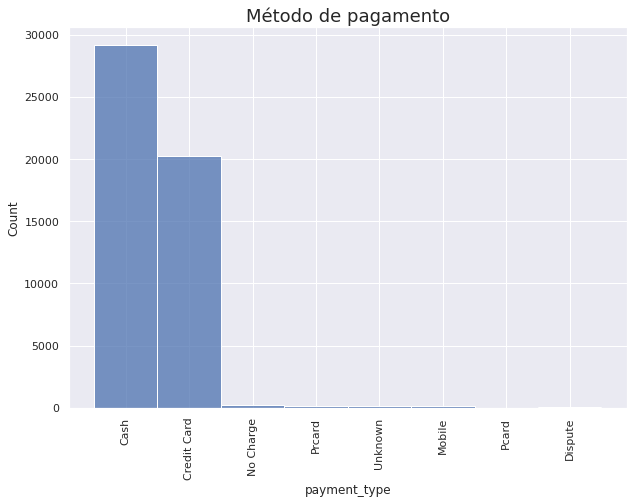

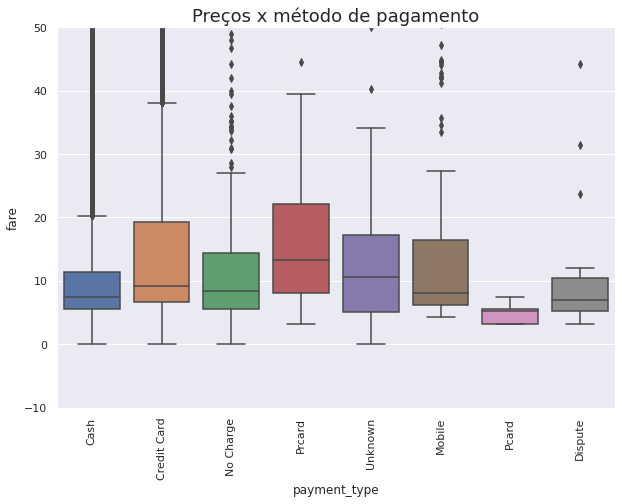


Custo total mediano de corridas pagas com dinheiro: 7.45
Custo total mediano de corridas pagas com crédito: 9.25



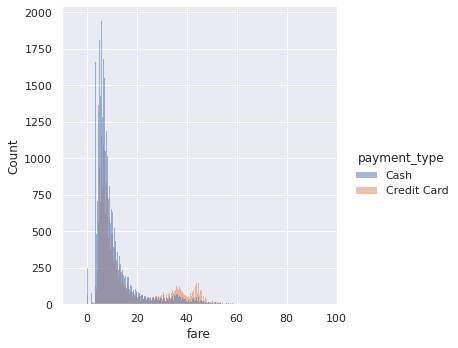

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize': (10, 7)})

sns.histplot(df['payment_type'])
plt.xticks(rotation=90)
plt.title('Método de pagamento', fontdict={'size': 18})
plt.show()
print()

# vamos ver agora se existem diferenças entre os preços 
plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize': (10, 7)})

sns.boxplot(x='payment_type', y='fare', data=df)
plt.xticks(rotation=90)
plt.title('Preços x método de pagamento', fontdict={'size': 18})
plt.ylim(-10, 50) # tem MUITO outlier no preço, então vamos dar uma limitada no eixo y pra ver um pouco melhor
plt.show()
print()

print("Custo total mediano de corridas pagas com dinheiro: {}".format(df[df['payment_type'] == 'Cash']['fare'].median()))
print("Custo total mediano de corridas pagas com crédito: {}".format(df[df['payment_type'] == 'Credit Card']['fare'].median()))
print()

# vamos procurar mais uma forma de ver como essas distribuições se comportam
plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize': (10, 7)})

sns.displot(data=df.loc[(df['payment_type'] == 'Credit Card') | (df['payment_type'] == 'Cash')], x="fare", hue="payment_type", kde=False)
plt.xlim(-10, 100)
plt.show()

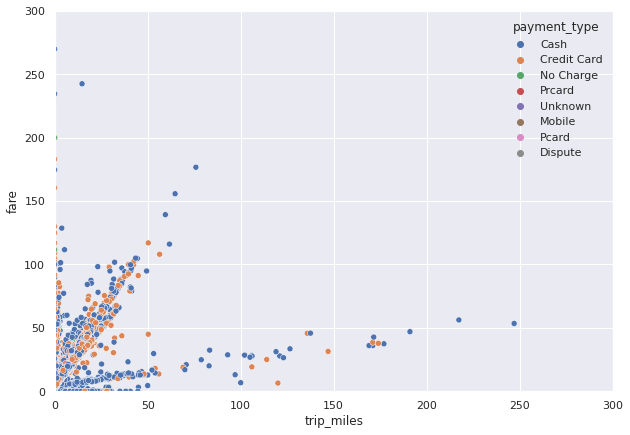

In [ ]:
sns.scatterplot(x='trip_miles', y='fare', data=df, hue='payment_type')
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.show()

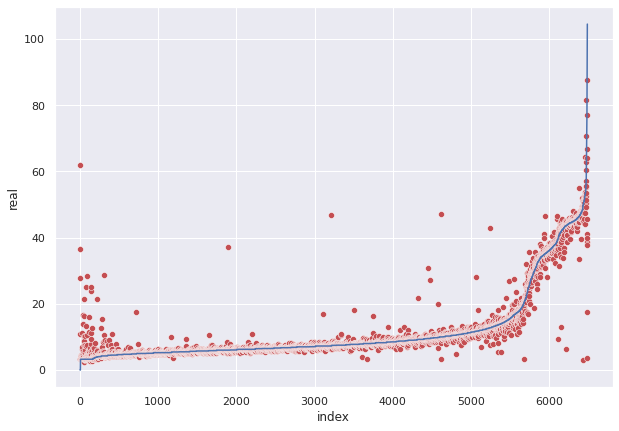

In [ ]:
# Também podemos analisar a performance do modelo de uma forma um pouco mais visual
df_plot_results = pd.DataFrame({'pred': y_pred,
                                'real': y_test}).sort_values(by=['real']).reset_index(drop=True) # organizado de forma crescente pra facilitar a visualização

df_plot_results['index'] = df_plot_results.index

sns.lineplot(x='index', y='real', data=df_plot_results) # valores reais como uma linha
sns.scatterplot(x='index', y='pred', data=df_plot_results, color='r') # valores previstos como dispersão
plt.show() # lembrando que esse é o resultado do modelo depois da eliminação dos valores nulos

Considerando que existe um diferença evidente entre os preços medianos das corridas pagas em dinheiro e em cartão e que esses dois grupos somados representam mais de 95% dos nossos dados, vamos ajustar modelos específicos para cada situação

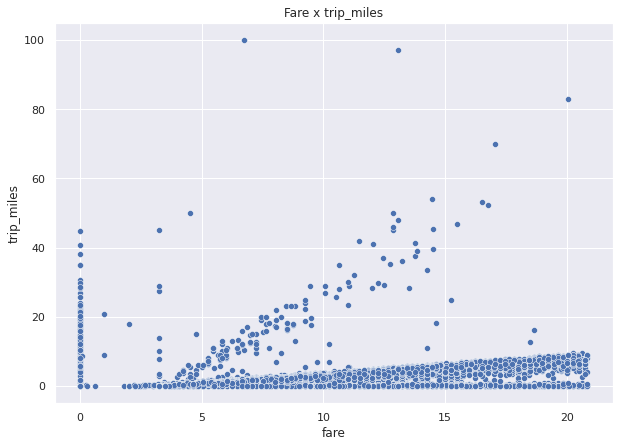

In [ ]:
df_cash = df[df['payment_type'] == 'Cash']
distancia_interquartil = df_cash['fare'].quantile(0.75) - df_cash['fare'].quantile(0.25)
limite_inferior = df_cash['fare'].quantile(0.25) - (1.5 * distancia_interquartil)
limite_superior = df_cash['trip_total'].quantile(0.75) + (1.5 * distancia_interquartil)
df_cash_limpo = df_cash[(df_cash['fare'] > limite_inferior) & (df_cash['fare'] < limite_superior)]

sns.scatterplot(x='fare', y='trip_miles', data=df_cash_limpo)
plt.title('Fare x trip_miles')
plt.show()

In [ ]:
dataframe_pra_regressao = df_cash_limpo.copy()

for column in dataframe_pra_regressao.columns:
  if dataframe_pra_regressao[column].dtype == 'object':
    dataframe_pra_regressao[column] = dataframe_pra_regressao[column].fillna(dataframe_pra_regressao[column].mode()[0])
    le = LabelEncoder()
    dataframe_pra_regressao[column] = le.fit_transform(dataframe_pra_regressao[column].astype('str'))
  else:
    dataframe_pra_regressao[column] = dataframe_pra_regressao[column].fillna(dataframe_pra_regressao[column].median())

x_columns = ['unique_key', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'pickup_location', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_location', 'ride_date']

y_column = 'fare'  

x_train, x_test, y_train, y_test = train_test_split(dataframe_pra_regressao[x_columns], dataframe_pra_regressao[y_column], train_size=0.7)
regression_model = RandomForestRegressor()
regression_model.fit(x_train, y_train)
y_pred = regression_model.predict(x_test)

error = y_test - y_pred
print('Custo médio da corrida ($): {}'. format(y_test.mean()))
print('Erro médio da previsão ($): {:1.3f}'. format(error.mean()))
print('Desvio padrão do erro ($): {}'. format( np.round(error.std(), 3) ))
print()

n_maiores_erros = round(len(y_test) * 0.001)

print(f'{n_maiores_erros} Maiores erros:')
print(error.sort_values(ascending=False)[:n_maiores_erros])
print()

print('Custo médio (limpo) da corrida ($): {}'. format(y_test.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Erro médio (limpo) da previsão ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Desvio padrão (limpo) do erro ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].std()))

Custo médio da corrida ($): 7.881745607333853
Erro médio da previsão ($): -0.020
Desvio padrão do erro ($): 1.09

8 Maiores erros:
10624    12.8670
31304    11.7609
1034     11.0297
32585    10.9515
8037      9.1055
38660     8.8950
11579     7.9030
29278     7.8425
Name: fare, dtype: float64

Custo médio (limpo) da corrida ($): 7.868586540912571
Erro médio (limpo) da previsão ($): -0.030468289574304475
Desvio padrão (limpo) do erro ($): 1.0409834985819937


(-1.0, 200.0)

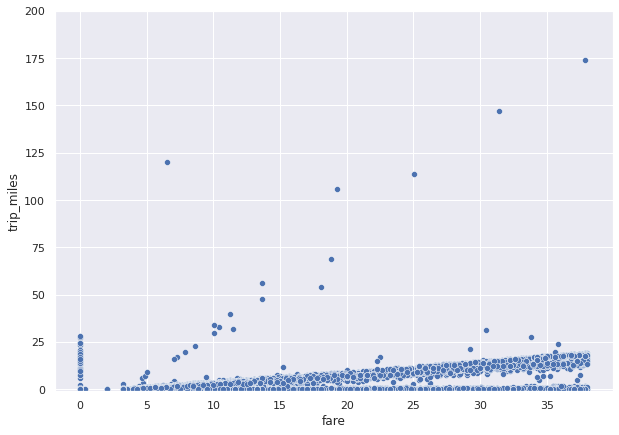

In [ ]:
df_cc = df[df['payment_type'] == 'Credit Card']
distancia_interquartil = df_cc['fare'].quantile(0.75) - df_cc['fare'].quantile(0.25)
limite_inferior = df_cc['fare'].quantile(0.25) - (1.5 * distancia_interquartil)
limite_superior = df_cc['fare'].quantile(0.75) + (1.5 * distancia_interquartil)
df_cc_limpo = df_cc[(df_cc['fare'] > limite_inferior) & (df_cc['fare'] < limite_superior)]

sns.scatterplot(x='fare', y='trip_miles', data=df_cc_limpo)
plt.ylim(-1, 200)

In [ ]:
dataframe_pra_regressao = df_cc_limpo.copy()

for column in dataframe_pra_regressao.columns:
  if dataframe_pra_regressao[column].dtype == 'object':
    dataframe_pra_regressao[column] = dataframe_pra_regressao[column].fillna(dataframe_pra_regressao[column].mode()[0])
    le = LabelEncoder()
    dataframe_pra_regressao[column] = le.fit_transform(dataframe_pra_regressao[column].astype('str'))
  else:
    dataframe_pra_regressao[column] = dataframe_pra_regressao[column].fillna(dataframe_pra_regressao[column].median())

x_columns = ['unique_key', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'pickup_location', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_location', 'ride_date']

y_column = 'fare'   

x_train, x_test, y_train, y_test = train_test_split(dataframe_pra_regressao[x_columns], dataframe_pra_regressao[y_column], train_size=0.7)
regression_model = RandomForestRegressor()
regression_model.fit(x_train, y_train)
y_pred = regression_model.predict(x_test)

error = y_test - y_pred
print('Custo médio da corrida ($): {}'. format(y_test.mean()))
print('Erro médio da previsão ($): {:1.3f}'. format(error.mean()))
print('Desvio padrão do erro ($): {}'. format( np.round(error.std(), 3) ))
print()

n_maiores_erros = round(len(y_test) * 0.001)

print(f'{n_maiores_erros} Maiores erros:')
print(error.sort_values(ascending=False)[:n_maiores_erros])
print()

print('Custo médio (limpo) da corrida ($): {}'. format(y_test.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Erro médio (limpo) da previsão ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Desvio padrão (limpo) do erro ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].std()))

Custo médio da corrida ($): 12.109121223286678
Erro médio da previsão ($): -0.023
Desvio padrão do erro ($): 2.921

5 Maiores erros:
11735    36.4751
7667     33.0142
35891    29.7707
13483    27.9975
44199    27.9515
Name: fare, dtype: float64

Custo médio (limpo) da corrida ($): 12.085203761755494
Erro médio (limpo) da previsão ($): -0.05136109164668655
Desvio padrão (limpo) do erro ($): 2.7638345033982303


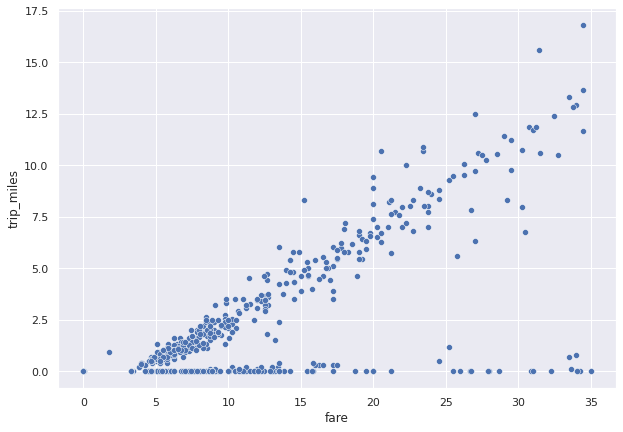

In [ ]:
df_outros = df[(df['payment_type'] != 'Credit Card') & (df['payment_type'] != 'Cash')]
distancia_interquartil = df_outros['fare'].quantile(0.75) - df_outros['fare'].quantile(0.25)
limite_inferior = df_outros['fare'].quantile(0.25) - (1.5 * distancia_interquartil)
limite_superior = df_outros['fare'].quantile(0.75) + (1.5 * distancia_interquartil)
df_outros_limpo = df_outros[(df_outros['fare'] > limite_inferior) & (df_outros['fare'] < limite_superior)]

sns.scatterplot(x='fare', y='trip_miles', data=df_outros_limpo)
plt.show()

In [ ]:
dataframe_pra_regressao = df_outros_limpo.copy()

for column in dataframe_pra_regressao.columns:
  if dataframe_pra_regressao[column].dtype == 'object':
    dataframe_pra_regressao[column] = dataframe_pra_regressao[column].fillna(dataframe_pra_regressao[column].mode()[0])
    le = LabelEncoder()
    dataframe_pra_regressao[column] = le.fit_transform(dataframe_pra_regressao[column].astype('str'))
  else:
    dataframe_pra_regressao[column] = dataframe_pra_regressao[column].fillna(dataframe_pra_regressao[column].median())
  
x_columns = ['unique_key', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'pickup_location', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_location', 'ride_date']

y_column = 'fare'  

x_train, x_test, y_train, y_test = train_test_split(dataframe_pra_regressao[x_columns], dataframe_pra_regressao[y_column], train_size=0.7)
regression_model = RandomForestRegressor()
regression_model.fit(x_train, y_train)
y_pred = regression_model.predict(x_test)

error = y_test - y_pred
print('Custo médio da corrida ($): {}'. format(y_test.mean()))
print('Erro médio da previsão ($): {:1.3f}'. format(error.mean()))
print('Desvio padrão do erro ($): {}'. format( np.round(error.std(), 3) ))
print()

n_maiores_erros = round(len(y_test) * 0.001)

print(f'{n_maiores_erros} Maiores erros:')
print(error.sort_values(ascending=False)[:n_maiores_erros])
print()

print('Custo médio (limpo) da corrida ($): {}'. format(y_test.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Erro médio (limpo) da previsão ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Desvio padrão (limpo) do erro ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].std()))

Custo médio da corrida ($): 11.480538922155688
Erro médio da previsão ($): -0.650
Desvio padrão do erro ($): 3.728

0 Maiores erros:
Series([], Name: fare, dtype: float64)

Custo médio (limpo) da corrida ($): 11.480538922155688
Erro médio (limpo) da previsão ($): -0.6499221556886233
Desvio padrão (limpo) do erro ($): 3.728139920334336


Ao todo repetimos aqui por 5 vezes os processos de treino e teste.
- O modelo baseline
- O modelo com a remoção de todos os registros onde ao menos 1 campro era faltante
- O modelo em que só olhamos para as corridas pagas em dinheiro
- O modelo em que só olhamos para as corridas pagas em cartão de crédito 
- O modelo com todas as outras formas de pagamento 

Aqui vão os pontos que eu achei mais interessantes na análise:

- Vamos notar que a ideia de remover apenas 1 milésimo dos erros ajudou a reduzir bastante a dispersão
- Apesar de não ter domínio sobre o negócio de corridas de taxi, me parece muito estranho esse número de corridas com deslocamento zero, mas ainda assim, cobradas. Se conseguirmos de alguma forma uma confirmação que isso de fato é um erro, podemos conseguir também pela eliminação desses registros, um belo aumento na precisão dos nossos modelos.


### Corridas com deslocamento zero

In [ ]:
# vamos dar uma olhada nessa história de corrida sem deslocamento
df_deslocamento_zero = df[df['trip_miles'] == 0].copy() # 20% do dataframe é muita coisa
df_deslocamento_zero

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,ride_date
0,d3c594ba6b3eb5f9644b9af3f1328aa82744ffd5,a0ac953f8cee6f14d8f2f15bf14b52de5caab289f7d599...,2019-09-13 23:00:00+00:00,2019-09-13 23:00:00+00:00,60.0,0.0,NaN,NaN,7.0,7.0,3.25,0.0,0.0,0.0,3.25,Cash,Taxi Affiliation Services,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),2019-09-13
7,8c7eb6c919ccc5197f9f97255f3eb5cd8ab6a0b1,07588fc5119d1c29249afc3e41417094185f808c12ff3d...,2013-02-22 21:15:00+00:00,2013-02-22 21:30:00+00:00,840.0,0.0,1.703106e+10,1.703103e+10,6.0,77.0,10.25,0.0,0.0,0.0,10.25,Cash,Northwest Management LLC,41.938391,-87.638575,POINT (-87.6385749205 41.938391257700005),41.978875,-87.657871,POINT (-87.6578712629 41.9788750584),2013-02-22
9,4b1fdec65845a7ec193ba5961ebad3c5c5887e1e,4a93570d0a8ed5da578f834e9baec432c9208a6ba791f4...,2013-01-25 23:30:00+00:00,2013-01-25 23:30:00+00:00,0.0,0.0,NaN,NaN,22.0,22.0,3.25,0.0,0.0,0.0,3.25,Cash,Taxi Affiliation Services,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),2013-01-25
18,6d2eb307a1479b85c4bb27f19e5e94c0f6dd649e,4e4abb335bca0979e1a79a7924b5a27145ef450f553457...,2015-05-09 13:15:00+00:00,2015-05-09 13:15:00+00:00,300.0,0.0,1.703108e+10,1.703108e+10,8.0,8.0,5.65,1.5,0.0,1.5,8.65,Credit Card,Taxi Affiliation Services,41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),41.907520,-87.626659,POINT (-87.6266589003 41.90752007470001),2015-05-09
22,61177fe387d8e6f4cf9204e70f04cea0cc641994,a06f7353c060caf90d8166268f92d6870bd5301a52eca7...,2015-12-27 20:30:00+00:00,2015-12-27 20:30:00+00:00,240.0,0.0,1.703108e+10,1.703108e+10,8.0,8.0,5.05,0.0,0.0,1.0,6.05,Cash,Taxi Affiliation Services,41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),41.895033,-87.619711,POINT (-87.6197106717 41.8950334495),2015-12-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49980,b953c75c172ea36d7be6b59be1e71307c6ed0c59,926aca65cddbfce7915dde52b9dad1eeba3a34763f280c...,2017-07-19 10:15:00+00:00,2017-07-19 10:30:00+00:00,600.0,0.0,1.703108e+10,1.703108e+10,8.0,8.0,7.50,1.0,0.0,0.0,8.50,Credit Card,Blue Ribbon Taxi Association Inc.,41.905858,-87.630865,POINT (-87.6308650266 41.9058577688),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2017-07-19
49981,b6236842d4f2b369f1419bd4f7c3bf29226b31e1,f263fd22fe110310064f8564447fc1d61520538844ce62...,2015-02-11 19:45:00+00:00,2015-02-11 20:00:00+00:00,600.0,0.0,NaN,NaN,22.0,21.0,7.45,0.0,0.0,0.0,7.45,Cash,Blue Ribbon Taxi Association Inc.,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),2015-02-11
49982,399382bf233500e8231ce46f6b95f40bd64ee6d6,42574f4a000f78c9ccbf2cfc282f31617096a9fea4a0d5...,2020-05-07 20:45:00+00:00,2020-05-07 20:45:00+00:00,120.0,0.0,NaN,NaN,76.0,76.0,5.50,0.0,0.0,0.0,5.50,Cash,Taxi Affiliation Services,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.980264,-87.913625,POINT (-87.913624596 41.9802643146),2020-05-07
49993,18f79d2ce9ad69932d8d67e2ec86039ce42021ed,7e24249ff4078bbd7a68ecfabe47936069ecb413481751...,2016-07-15 08:00:00+00:00,2016-07-15 08:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,9.50,1.0,0.0,0.0,10.50,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-15


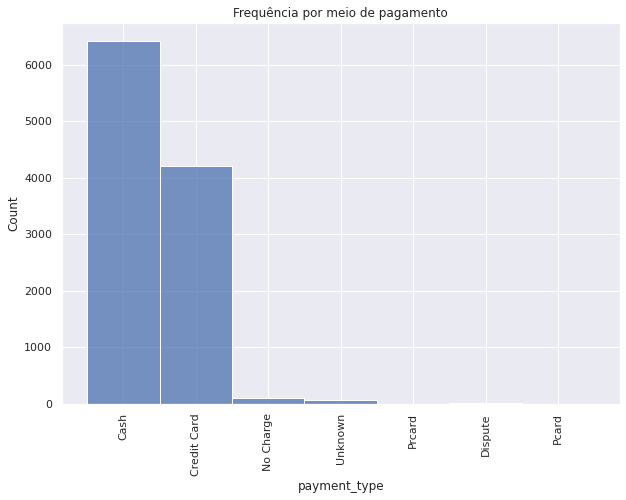

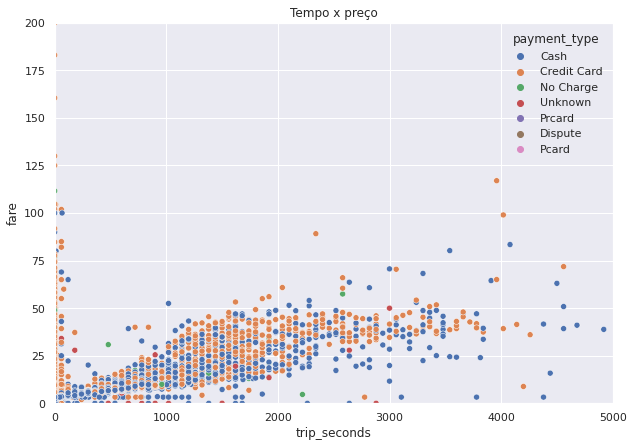

In [ ]:
sns.histplot(df_deslocamento_zero['payment_type'])
plt.xticks(rotation=90)
plt.title('Frequência por meio de pagamento')
plt.show()
print()

sns.scatterplot(x='trip_seconds', y='fare', data=df_deslocamento_zero, hue='payment_type') # relação entre tempo de corrida e preço nos casos de deslocamento zero segmentada por meio de pagamento
plt.xlim(0, 5000)
plt.ylim(0, 200)
plt.title('Tempo x preço')
plt.show()

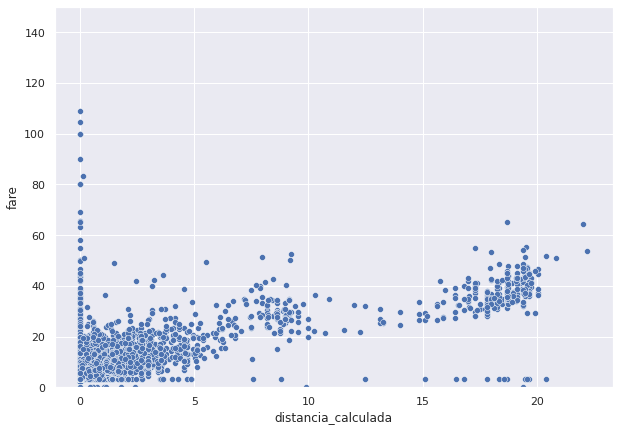

In [ ]:
import haversine as hs
from haversine import Unit

# vamos calcular as distâncias baseadas nas coordenadas geográficas dos pontos de inicio e fim das corridas
df_deslocamento_zero['distancia_calculada'] = [hs.haversine((pickup_longitude, pickup_latitude), (dropoff_longitude, dropoff_latitude), unit=Unit.MILES) for pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
                                               in zip(df_deslocamento_zero['pickup_longitude'], df_deslocamento_zero['pickup_latitude'], df_deslocamento_zero['dropoff_longitude'], df_deslocamento_zero['dropoff_latitude'])]  
                                     

sns.scatterplot(x='distancia_calculada', y='fare', data=df_deslocamento_zero)
plt.ylim(0, 150)
plt.show()

In [ ]:
df['distancia_calculada'] = [hs.haversine((pickup_latitude, pickup_longitude), (dropoff_latitude, dropoff_longitude), unit=Unit.MILES) for pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
                             in zip(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])]  

df_com_deslocamento = df[df['trip_miles'] > 0].dropna()
distance_difference = (df_com_deslocamento['distancia_calculada'] - df_com_deslocamento['trip_miles'])/df_com_deslocamento['distancia_calculada']

distance_difference

2         0.937295
4        -0.533689
5       -14.709759
10       -0.236790
11       -0.117138
           ...    
49974    -0.195486
49979     0.346123
49991    -0.537253
49994     0.321440
49997    -0.102552
Length: 15959, dtype: float64

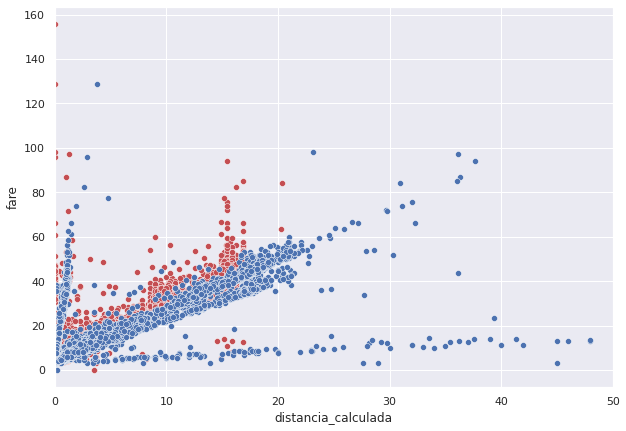

In [ ]:
sns.scatterplot(x='distancia_calculada', y='fare', color='r', data=df_com_deslocamento)
sns.scatterplot(x='trip_miles', y='fare', color='b', data=df_com_deslocamento)
plt.xlim(0, 50)
plt.show()

Percebemos que tem muito dado com valores diferentes entre calculado e o valor de distância forncecido, mas visualmente fica meio difícil perceber qual aparenta ter uma correlação melhor com o preço da corrida.

Pra isso temos um método que simplifica bem a nossa vida.

In [ ]:
# visualindo a matriz de correlação 
df_com_deslocamento.corr() # tão simples quanto isso

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distancia_calculada
trip_seconds,1.000000,0.290048,0.162187,0.105217,0.246590,0.177933,0.456680,0.277969,NaN,0.278544,0.448199,0.135234,-0.294790,0.106432,-0.238895,0.415875
trip_miles,0.290048,1.000000,0.230145,0.158450,0.352959,0.260089,0.653506,0.388263,NaN,0.417202,0.641508,0.223949,-0.439887,0.180811,-0.362020,0.631420
pickup_census_tract,0.162187,0.230145,1.000000,0.006089,0.778730,0.015704,0.353159,0.278077,NaN,0.337470,0.369785,0.004281,-0.531680,-0.032397,-0.000385,0.358790
dropoff_census_tract,0.105217,0.158450,0.006089,1.000000,0.016935,0.739698,0.229720,0.152746,NaN,0.032072,0.218590,-0.048990,0.028260,-0.121606,-0.468722,0.223444
pickup_community_area,0.246590,0.352959,0.778730,0.016935,1.000000,0.036027,0.529658,0.400037,NaN,0.512489,0.551543,0.180361,-0.771001,-0.048677,0.006404,0.545210
dropoff_community_area,0.177933,0.260089,0.015704,0.739698,0.036027,1.000000,0.386238,0.243019,NaN,0.087754,0.367630,-0.058353,0.026842,0.022654,-0.701130,0.389009
fare,0.456680,0.653506,0.353159,0.229720,0.529658,0.386238,1.000000,0.631737,NaN,0.614757,0.986344,0.308693,-0.645850,0.249226,-0.533436,0.939889
tips,0.277969,0.388263,0.278077,0.152746,0.400037,0.243019,0.631737,1.000000,NaN,0.413044,0.738376,0.194908,-0.469271,0.124087,-0.315503,0.634940
tolls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
extras,0.278544,0.417202,0.337470,0.032072,0.512489,0.087754,0.614757,0.413044,NaN,1.000000,0.665982,0.249418,-0.637737,0.035306,-0.131007,0.598210


In [ ]:
# pra focar só no que a gente quer ver agora, podemos fatiar o dataframe
df_com_deslocamento.corr().loc[['trip_miles', 'distancia_calculada']][['trip_total']] # distância calculada soa BEM melhor

,trip_total
trip_miles,0.641508
distancia_calculada,0.936034


Se no dataframe com todas as informações presentes, a correlação é boa entre distância calculada e preço, vamos extrapolar isso para os registros que apresentam, também, dados faltantes.

Vamos continuar eliminando os outliers presentes apenas na coluna fare

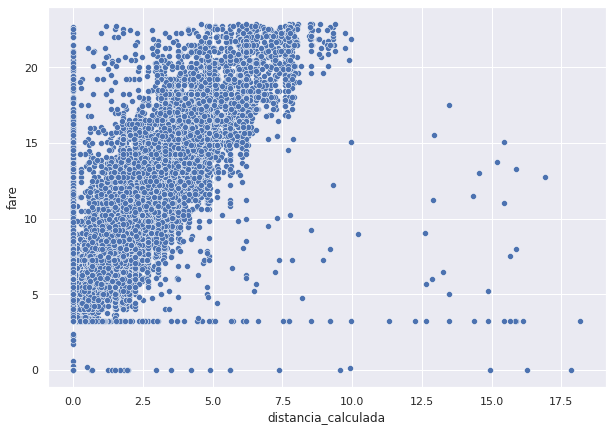

In [ ]:
df_limpo = df.dropna(subset=['distancia_calculada'])

distancia_interquartil = df_limpo['fare'].quantile(0.75) - df_limpo['fare'].quantile(0.25)
limite_inferior = df_limpo['fare'].quantile(0.25) - (1.5 * distancia_interquartil)
limite_superior = df_limpo['fare'].quantile(0.75) + (1.5 * distancia_interquartil)
df_limpo = df_limpo[(df_limpo['fare'] > limite_inferior) & (df_limpo['fare'] < limite_superior)] # como o limite inferior < 0, as corridas sem cobrança seguem no dataframe

sns.scatterplot(x='distancia_calculada', y='fare', data=df_limpo)
plt.show()

In [ ]:
dataframe_pra_regressao = df_limpo.copy()

for column in dataframe_pra_regressao.columns:
  if dataframe_pra_regressao[column].dtype == 'object':
    dataframe_pra_regressao[column] = dataframe_pra_regressao[column].fillna(dataframe_pra_regressao[column].mode()[0])
    le = LabelEncoder()
    dataframe_pra_regressao[column] = le.fit_transform(dataframe_pra_regressao[column].astype('str'))
  else:
    dataframe_pra_regressao[column] = dataframe_pra_regressao[column].fillna(dataframe_pra_regressao[column].median())
  
x_columns = ['unique_key', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'pickup_location', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_location', 'ride_date']

y_column = 'fare'  

x_train, x_test, y_train, y_test = train_test_split(dataframe_pra_regressao[x_columns], dataframe_pra_regressao[y_column], train_size=0.7)
regression_model = RandomForestRegressor()
regression_model.fit(x_train, y_train)
y_pred = regression_model.predict(x_test)

error = y_test - y_pred
print('Custo médio da corrida ($): {}'. format(y_test.mean()))
print('Erro médio da previsão ($): {:1.3f}'. format(error.mean()))
print('Desvio padrão do erro ($): {}'. format( np.round(error.std(), 3) ))
print()

n_maiores_erros = round(len(y_test) * 0.001)

print(f'{n_maiores_erros} Maiores erros:')
print(error.sort_values(ascending=False)[:n_maiores_erros])
print()

print('Custo médio (limpo) da corrida ($): {}'. format(y_test.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Erro médio (limpo) da previsão ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Desvio padrão (limpo) do erro ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].std()))

Custo médio da corrida ($): 8.441824830538712
Erro médio da previsão ($): 0.012
Desvio padrão do erro ($): 0.991

11 Maiores erros:
13002    16.9228
26715    13.3420
18449    13.2690
46026    13.1705
30492    11.7530
18324     9.3040
6713      9.2745
10624     9.0375
14082     8.9380
11321     8.6825
31304     8.6450
Name: fare, dtype: float64

Custo médio (limpo) da corrida ($): 8.427728774216597
Erro médio (limpo) da previsão ($): 0.0014738951879299086
Desvio padrão (limpo) do erro ($): 0.9246052245064079


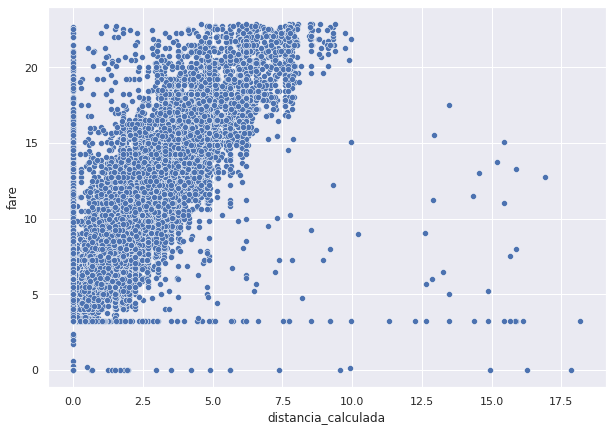

In [ ]:
sns.scatterplot(x='distancia_calculada', y='fare', data=df_limpo)

In [ ]:
shape = df_limpo[(df_limpo['distancia_calculada'] == 0) & (df_limpo['fare'] > 0)].shape
print(f'{shape[0]} linhas sem deslocamento, mas com custo')

4678 linhas sem deslocamento, mas com custo


Tudo bem. Eu até entendo que por alguma questão de marketing pode ter corridas com distância calculada, mas sem pagamento. O que eu ainda não entendo e pode até ser que faça sentido em algum contexto, são as corridas com custo, mas sem deslocamento.

In [ ]:
dataframe_pra_regressao = df_limpo[(df_limpo['distancia_calculada'] > 0) & (df_limpo['fare'] > 0)].copy() # testando o modelo apenas com distancias e custos maiores que zero

for column in dataframe_pra_regressao.columns:
  if dataframe_pra_regressao[column].dtype == 'object':
    dataframe_pra_regressao[column] = dataframe_pra_regressao[column].fillna(dataframe_pra_regressao[column].mode()[0])
    le = LabelEncoder()
    dataframe_pra_regressao[column] = le.fit_transform(dataframe_pra_regressao[column].astype('str'))
  else:
    dataframe_pra_regressao[column] = dataframe_pra_regressao[column].fillna(dataframe_pra_regressao[column].median())
  
x_columns = ['trip_seconds', 'trip_miles','payment_type', 'company',  'pickup_location',
             'dropoff_location', 'ride_date', 'distancia_calculada']

y_column = 'fare'  

x_train, x_test, y_train, y_test = train_test_split(dataframe_pra_regressao[x_columns], dataframe_pra_regressao[y_column], train_size=0.7)
regression_model = RandomForestRegressor()
regression_model.fit(x_train, y_train)
y_pred = regression_model.predict(x_test)

error = y_test - y_pred
print('Custo médio da corrida ($): {}'. format(y_test.mean()))
print('Erro médio da previsão ($): {:1.3f}'. format(error.mean()))
print('Desvio padrão do erro ($): {}'. format( np.round(error.std(), 3) ))
print()

n_maiores_erros = round(len(y_test) * 0.001)

print(f'{n_maiores_erros} Maiores erros:')
print(error.sort_values(ascending=False)[:n_maiores_erros])
print()

print('Custo médio (limpo) da corrida ($): {}'. format(y_test.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Erro médio (limpo) da previsão ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].mean()))
print('Desvio padrão (limpo) do erro ($): {}'.format(error.sort_values(ascending=False)[n_maiores_erros:].std()))

Custo médio da corrida ($): 8.878058163265328
Erro médio da previsão ($): -0.018
Desvio padrão do erro ($): 0.698

10 Maiores erros:
7849     8.6525
23001    8.1455
32319    7.2150
10124    7.0521
35565    6.9301
35090    5.5558
29106    5.4365
4637     5.2852
9442     5.0455
48871    4.9395
Name: fare, dtype: float64

Custo médio (limpo) da corrida ($): 8.863827374872338
Erro médio (limpo) da previsão ($): -0.024120684371807182
Desvio padrão (limpo) do erro ($): 0.6664458188999364


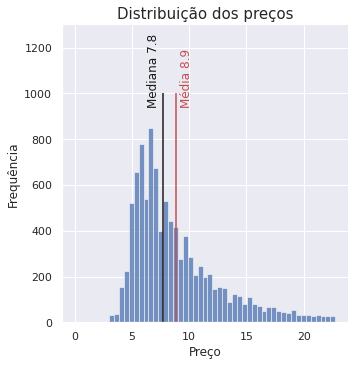

In [ ]:
y_test.sort_values(ascending=False)[n_maiores_erros:].median()
sns.displot(y_test.sort_values(ascending=False)[n_maiores_erros:])
media = y_test.sort_values(ascending=False)[n_maiores_erros:].mean()
plt.vlines(media, 0, 1000, color='r') # media 
plt.annotate(f'Média {np.round(media, 1)}', xy=(media + 0.3, 950), rotation=90, ha='left', color='r')

mediana = y_test.sort_values(ascending=False)[n_maiores_erros:].median()
plt.vlines(mediana, 0, 1000, color='k') # mediana 
plt.annotate(f'Mediana {np.round(mediana, 1)}', xy=(mediana - 0.3, 950), rotation=90, ha='right', color='k')
plt.title('Distribuição dos preços', fontdict={'size': 15})
plt.ylim(0, 1300)

plt.ylabel('Frequência')
plt.xlabel('Preço')

plt.show()


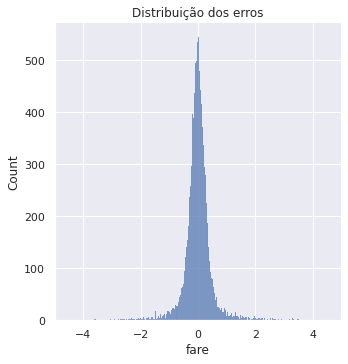

In [ ]:
sns.displot(error)
plt.title('Distribuição dos erros')
plt.xlim(-5, 5)
plt.show()

Lembra que eu comentei la em cima que remover os registros cobrados sem deslocamento poderia melhorar bem os resultados? Pois é. Acho que não melhorou muito, mas já é alguma coisa.

## Avaliação do modelo


Vamos parar aqui por enquanto. O que descobrimos?

- Descobrimos que da pra fazer um modelo que erra relativamentemente pouco com poucas colunas e sem um esforço muito grande em feature engineering nem em otimizar o modelo. Isso porque o volume de dados ja ajuda bem.
- Descobrimos que da pra eliminar algumas variáveis pra simplificar o modelo sem necessáriamentoe perder qualidade.
- Descobrimos que independente do formato da distribuição dos preços, o erro segue uma normal e isso simplifica bastante a nossa interpretação 
- Considerando a média de 9 dólares (usd) para o custo da corrida, podemos dizer que nosso modelo erra no máximo usd 1.3 pra mais ou pra menos em 95% dos casos

O que falta descobrir?
- Qual é o impacto de procedimentos de otimização do modelo?
- Quais variáveis poderiam nos ajudar a reduzir a dispersão dos erros? Pergunto isso porque apesar de ser um erro "legal", me incomoda que por exemplo 27000 registros de corridas pagas em dinheiro, não possibilitem erros ainda menores.
- Apesar de a distancia calculada ter uma correlação bem mais forte com o preço, a distância disponibilizada tem, por algum motivo que eu não identifiquei nessa análise, uma participação importante na precisão do modelo. Pra verificar isso, experimente seguir removendo as x_columns no último modelo e acompanhe a variação do resultado.
- Da pra considerar que a capacidade do nosso modelo em acertar a realidade é mesmo essa porque a remoção dos outliers elimina um número muito pequeno pra fazer a gente se preocupar. 
- Sera que nosso erro é uniforme pra todos os valores ou ele tem alguma correlação com o custo? Seria bom que sim, porque usd 1.3 em uma corrida que custa usd 5 representa um impacto muito maior os mesmo usd 1.3 em uma corrida que custa  usd 20.

